In [7]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import subtitle
from glob import glob
%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [2]:
# Dataset directory
DATASET_DIR = os.path.join('/data/steeve/mask_rcnn/data/')

# Inference Configuration
config = subtitle.SubtitleInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANC

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [8]:
video_id = 'VPQsgyKiONY'
dataset_dir = '/data/ITRI-create-speech-recognition-dataset/mandarin/frames'
image_ids = glob(dataset_dir + f'/{video_id}*')

In [10]:
# Load validation dataset
dataset = subtitle.SubtitleDataset()
dataset.load_subtitle(DATASET_DIR, "test", image_ids)
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 4421
Classes: ['BG', 'subtitle']


In [11]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [15]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"

# Or, load the last model you trained
weights_path = '/data/ITRI-create-speech-recognition-dataset/Mask_RCNN/logs/subtitle20180628T1420/mask_rcnn_subtitle_0069.h5'

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /data/ITRI-create-speech-recognition-dataset/Mask_RCNN/logs/subtitle20180628T1420/mask_rcnn_subtitle_0069.h5
Re-starting from epoch 69


In [ ]:
image = model.load

In [16]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

FileNotFoundError: [Errno 2] No such file or directory: '/data/steeve/mask_rcnn/data//multi_masks//data/ITRI-create-speech-recognition-dataset/mandarin/frames/VPQsgyKiONY-0000342-2.0.png.npy'

In [17]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

NameError: name 'image' is not defined

In [18]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

NameError: name 'image' is not defined

In [15]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 100254, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.10124  max:    1.05931  float32
refined_anchors          shape: (1, 6000, 4)          min:   -2.32934  max:    3.99539  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (2000,)               min:    0.00000  max: 2588.00000  int32
proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


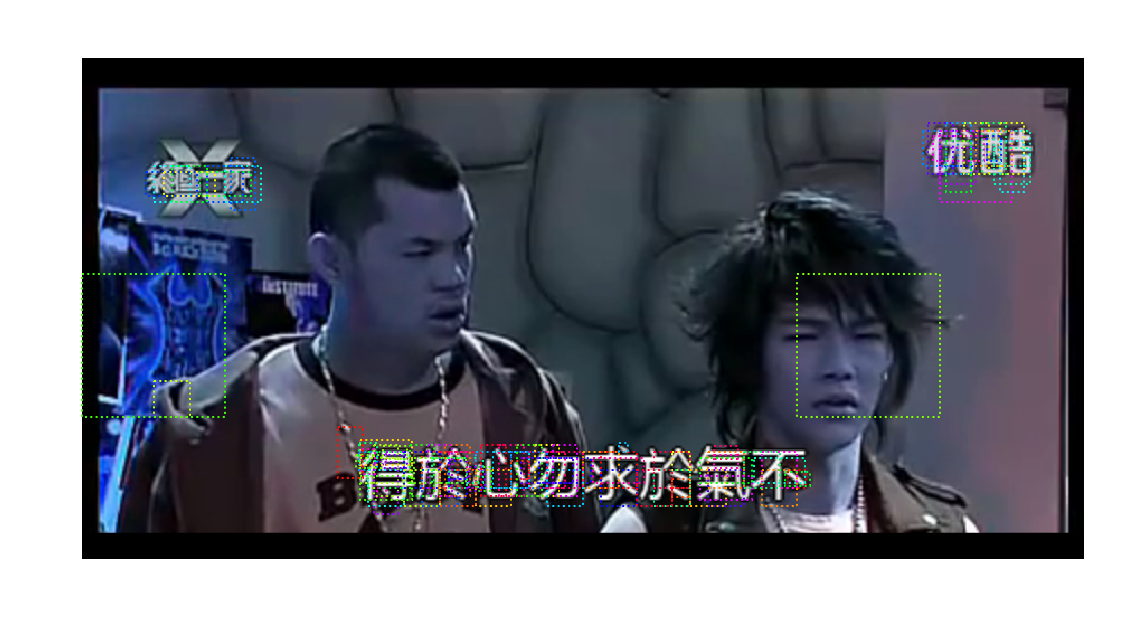

In [16]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

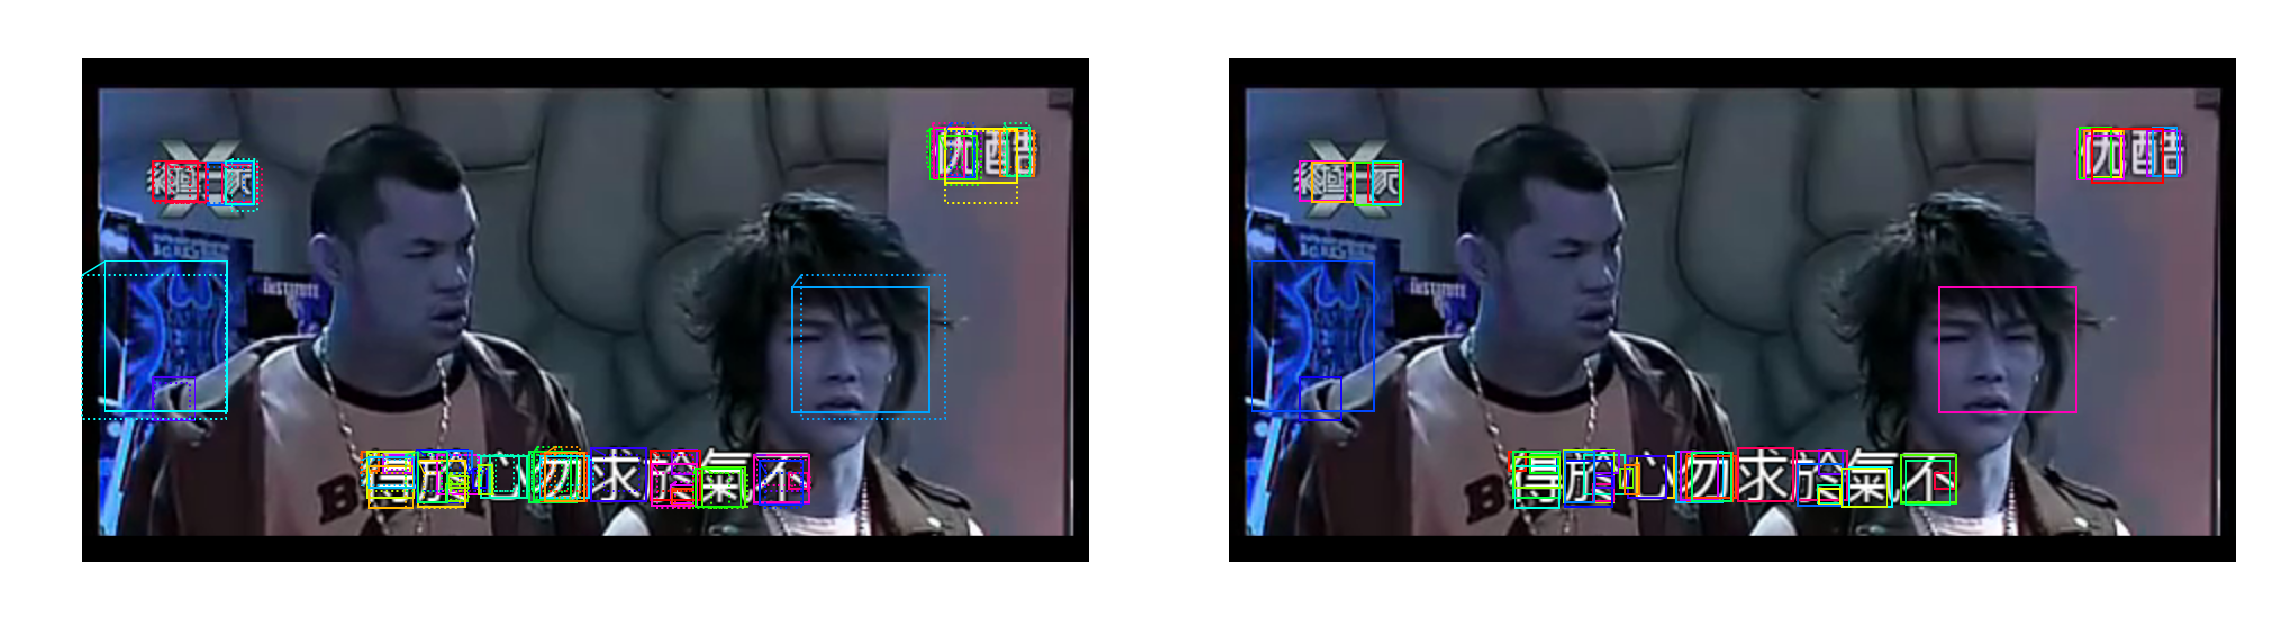

In [17]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(
    image, ax=ax[0],
    boxes=utils.denorm_boxes(rpn["pre_nms_anchors"][0, :limit], image.shape[:2]), 
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors"][0, :limit], image.shape[:2]))
visualize.draw_boxes(
    image, ax=ax[1],
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors_clipped"][0, :limit], image.shape[:2]))

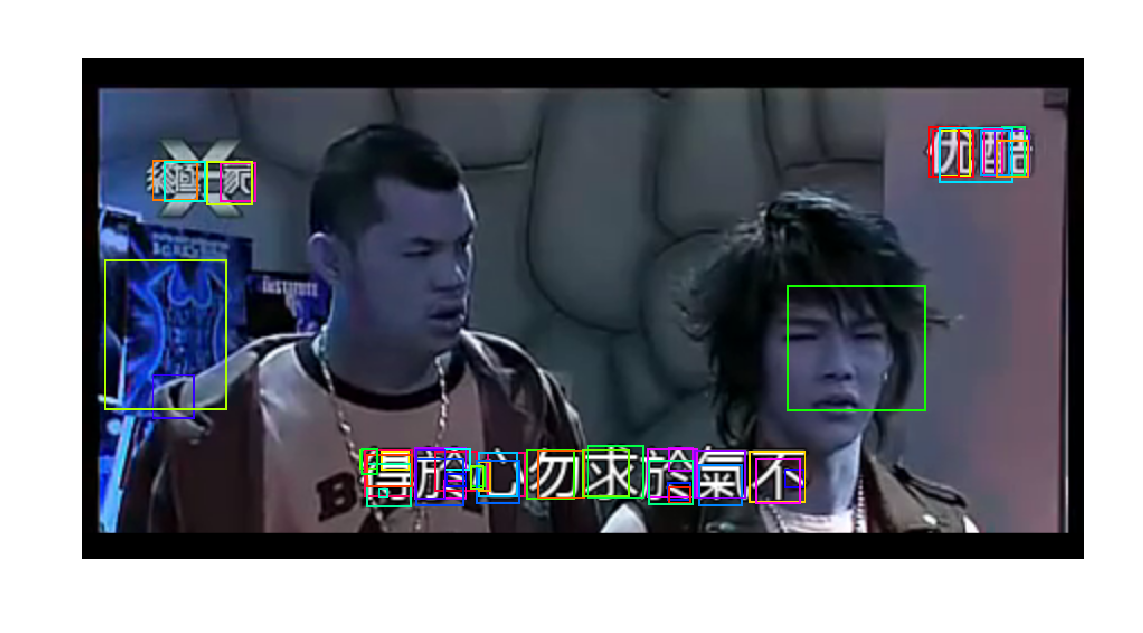

In [18]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors_clipped"][0, ixs], image.shape[:2]))

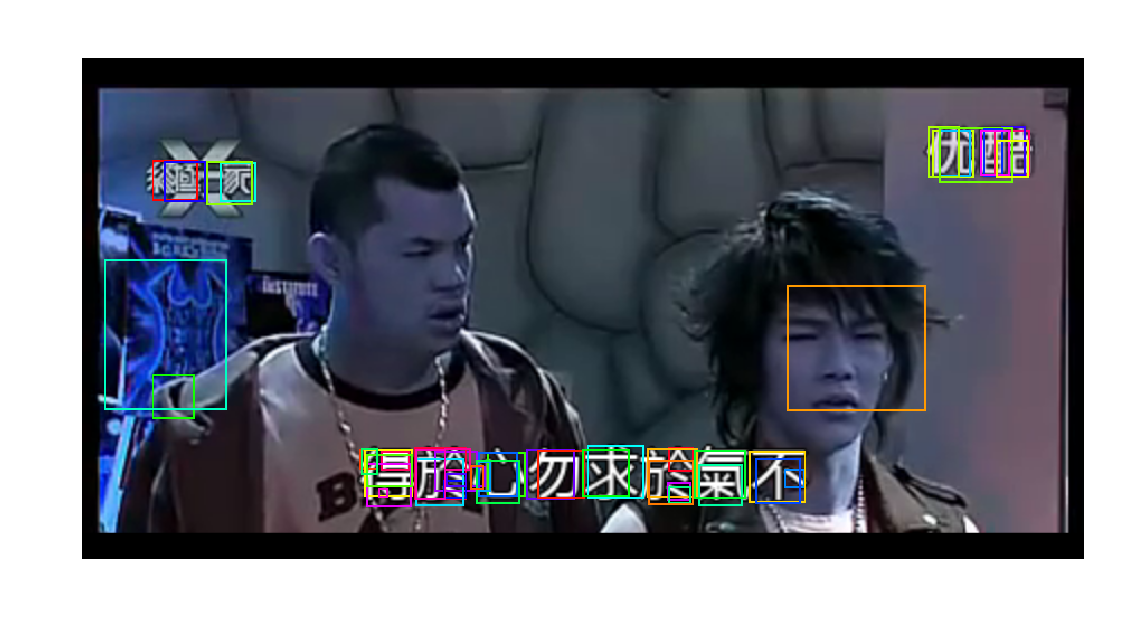

In [19]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

In [20]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 2000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 2000, 2, 4)       min:   -3.06943  max:    3.61545  float32
masks                    shape: (1, 50, 28, 28, 2)    min:    0.00000  max:    0.99960  float32
detections               shape: (1, 50, 6)            min:    0.00000  max:    1.00000  float32


39 detections: ['subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle']


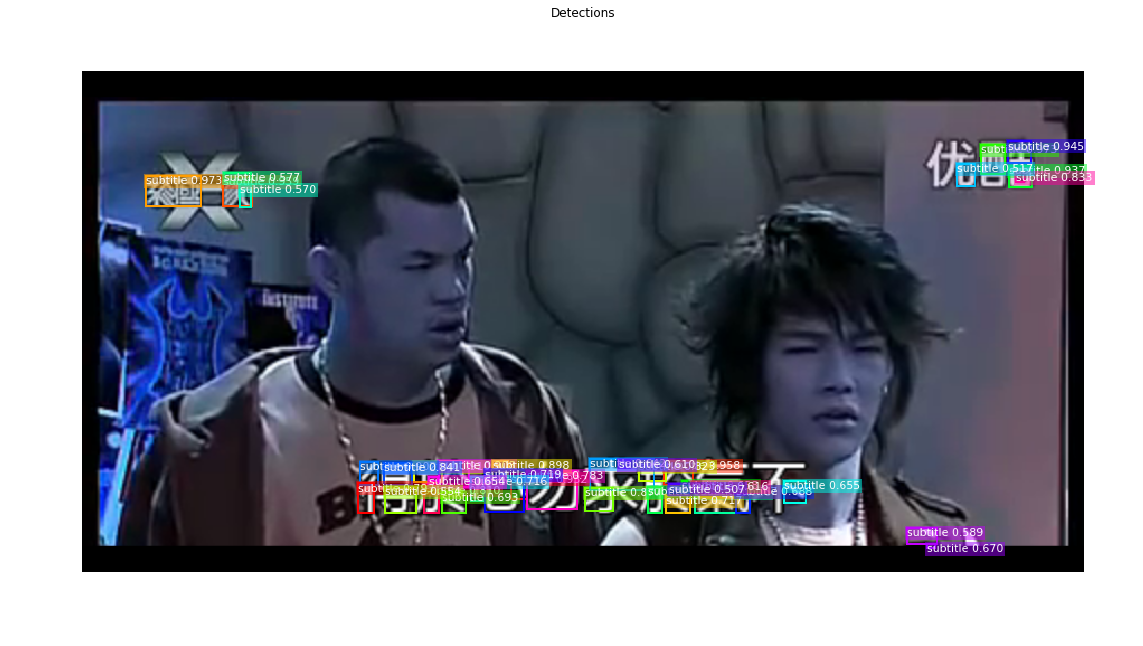

In [21]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [22]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

2000 Valid proposals out of 2000
166 Positive ROIs
[('BG', 1834), ('subtitle', 166)]


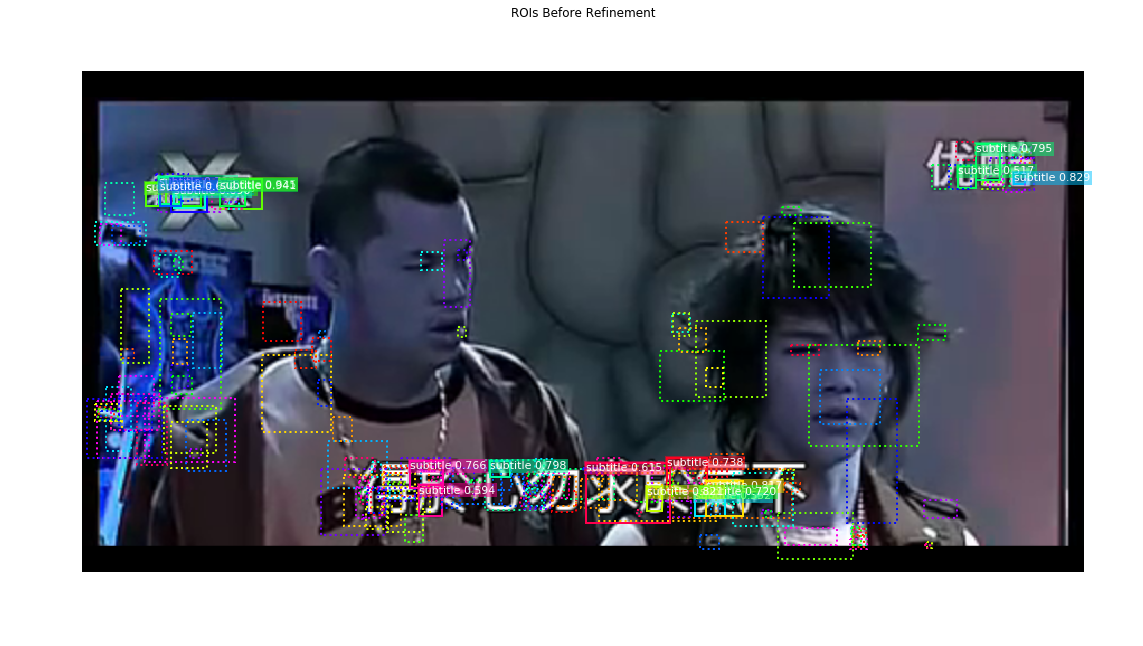

In [23]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

roi_bbox_specific        shape: (2000, 4)             min:   -2.43038  max:    3.44621  float32
refined_proposals        shape: (2000, 4)             min:   -0.00000  max:    1.00968  float32


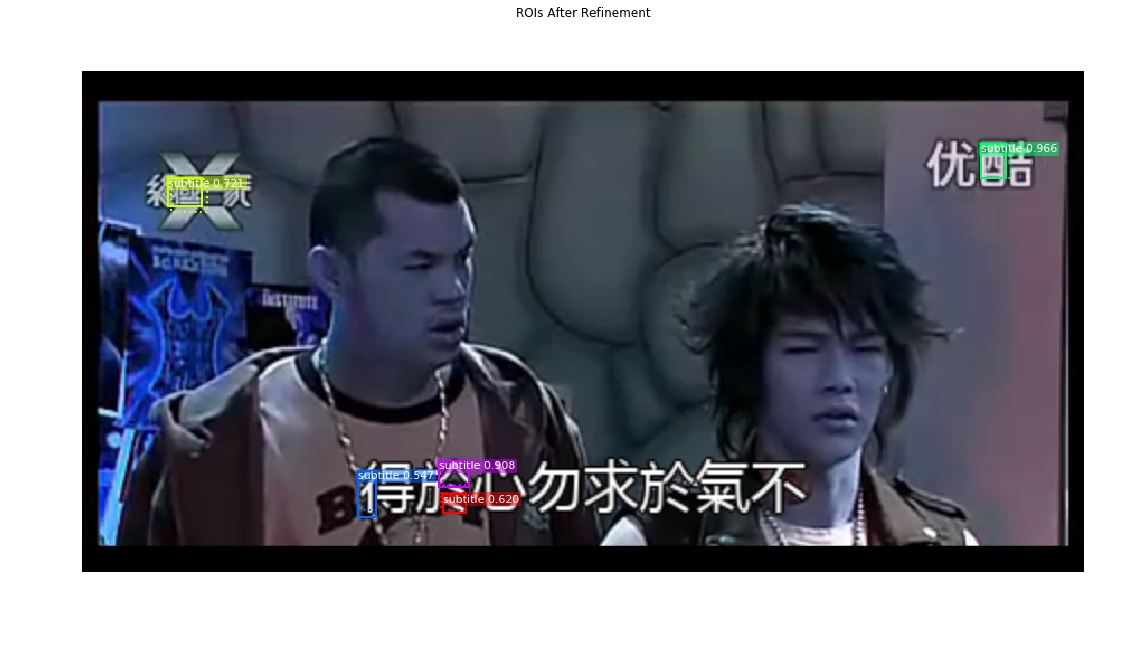

In [24]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

In [25]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 166 detections:
[   0    1    2    3    4    5   11   12   13   14   16   18   22   23
   24   27   28   30   33   35   37   38   39   42   45   46   48   49
   54   57   58   59   70   78   79   81   84   88   89   92   93   94
  101  104  107  109  110  111  117  118  124  125  127  130  135  139
  140  143  148  149  152  156  159  162  163  176  178  192  195  208
  209  213  217  219  225  233  245  257  261  275  280  305  307  321
  323  331  347  362  383  396  397  406  412  425  443  446  475  487
  489  500  507  511  515  534  539  540  541  548  555  603  634  636
  649  664  668  679  683  727  760  769  770  787  824  828  829  872
  911  913  961  975  998 1032 1057 1074 1134 1160 1178 1252 1282 1295
 1301 1312 1314 1344 1366 1379 1397 1460 1506 1571 1587 1615 1674 1685
 1687 1688 1806 1846 1862 1868 1883 1893 1898 1932 1958 1981]


In [26]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0 confidence. Keep 166:
[   0    1    2    3    4    5   11   12   13   14   16   18   22   23
   24   27   28   30   33   35   37   38   39   42   45   46   48   49
   54   57   58   59   70   78   79   81   84   88   89   92   93   94
  101  104  107  109  110  111  117  118  124  125  127  130  135  139
  140  143  148  149  152  156  159  162  163  176  178  192  195  208
  209  213  217  219  225  233  245  257  261  275  280  305  307  321
  323  331  347  362  383  396  397  406  412  425  443  446  475  487
  489  500  507  511  515  534  539  540  541  548  555  603  634  636
  649  664  668  679  683  727  760  769  770  787  824  828  829  872
  911  913  961  975  998 1032 1057 1074 1134 1160 1178 1252 1282 1295
 1301 1312 1314 1344 1366 1379 1397 1460 1506 1571 1587 1615 1674 1685
 1687 1688 1806 1846 1862 1868 1883 1893 1898 1932 1958 1981]


In [27]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

subtitle              : [   0    1    2    3    4    5   11   12   13   14   16   18   22   23
   24   27   28   30   33   35   37   38   39   42   45   46   48   49
   54   57   58   59   70   78   79   81   84   88   89   92   93   94
  101  104  107  109  110  111  117  118  124  125  127  130  135  139
  140  143  148  149  152  156  159  162  163  176  178  192  195  208
  209  213  217  219  225  233  245  257  261  275  280  305  307  321
  323  331  347  362  383  396  397  406  412  425  443  446  475  487
  489  500  507  511  515  534  539  540  541  548  555  603  634  636
  649  664  668  679  683  727  760  769  770  787  824  828  829  872
  911  913  961  975  998 1032 1057 1074 1134 1160 1178 1252 1282 1295
 1301 1312 1314 1344 1366 1379 1397 1460 1506 1571 1587 1615 1674 1685
 1687 1688 1806 1846 1862 1868 1883 1893 1898 1932 1958 1981] -> [ 541   12  307    5    1    2 1587   23   13  828  534   24  321  110
  603   22   27   14   28 1134 1846 1615  149   42  148   7

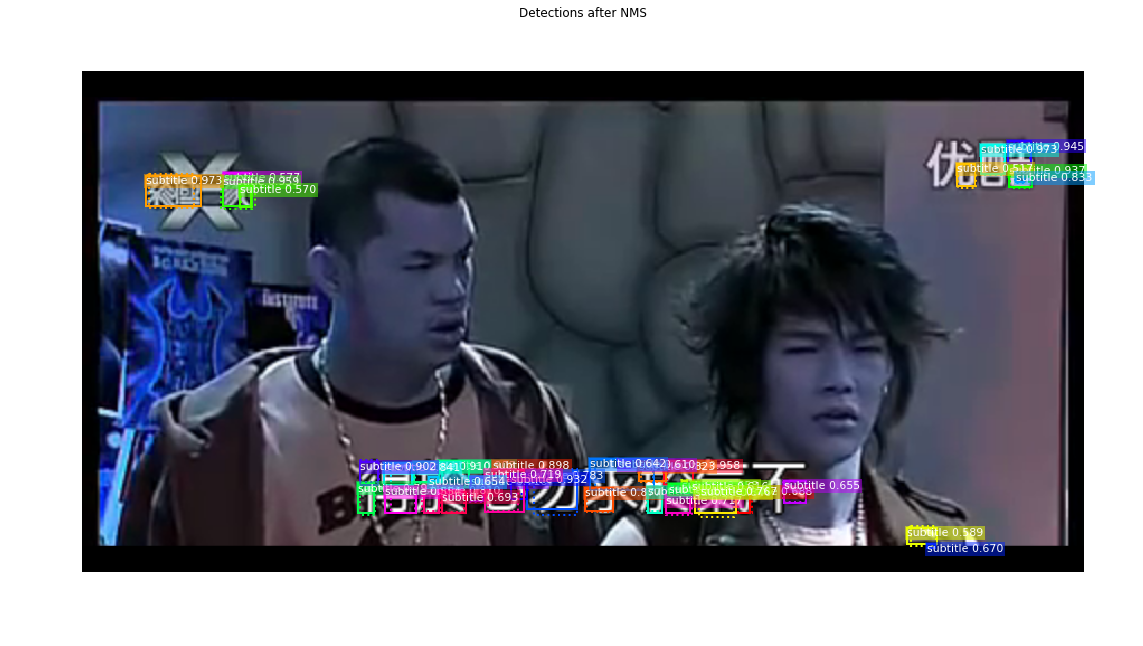

In [28]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

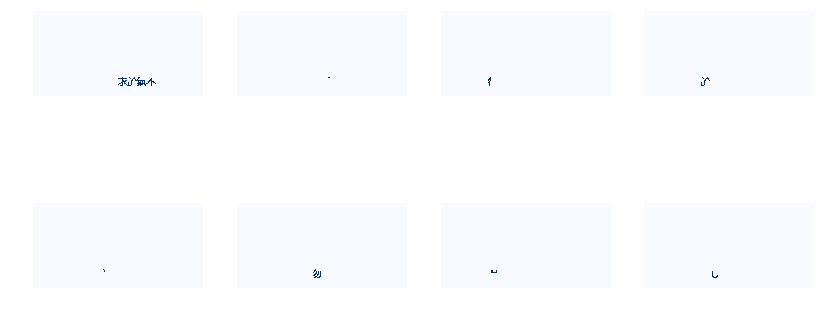

In [29]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

In [31]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 50, 6)            min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 50, 28, 28, 2)    min:    0.00000  max:    0.99960  float32
39 detections: ['subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle' 'subtitle'
 'subtitle' 'subtitle' 'subtitle']


In [32]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (39, 28, 28)          min:    0.00000  max:    0.99960  float32
det_masks                shape: (39, 448, 896)        min:    0.00000  max:    1.00000  bool


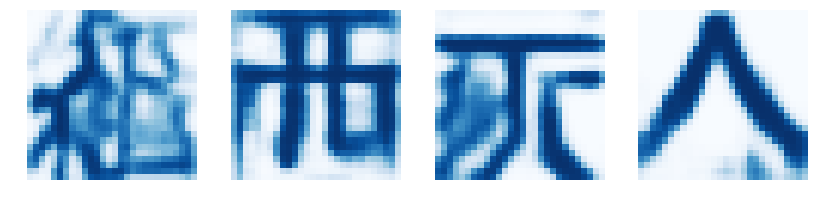

In [33]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

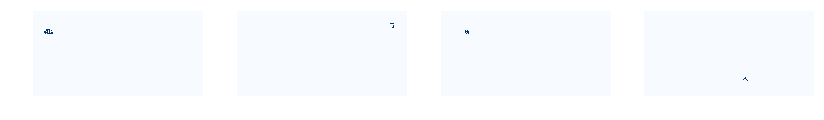

In [34]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

In [35]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 896, 1792, 3)     min:  -48.22000  max:  215.44000  float32
res2c_out                shape: (1, 224, 448, 256)    min:    0.00000  max:   26.48192  float32
res3c_out                shape: (1, 112, 224, 512)    min:    0.00000  max:   28.67074  float32
rpn_bbox                 shape: (1, 401016, 4)        min:  -12.31357  max:   95.96571  float32
roi                      shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


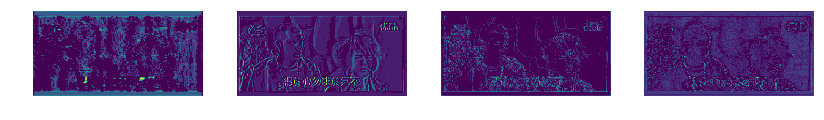

In [36]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

In [71]:
config = subtitle.SubtitleInferenceConfig()
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=subtitle.DEFAULT_LOGS_DIR)
weights_path= '/home/A60174/ITRI-create-speech-recognition-dataset/Mask_RCNN_Keras/logs/subtitle20180628T1420/mask_rcnn_subtitle_0040.h5'
model.load_weights(weights_path, by_name=True)

Re-starting from epoch 40
